# Crystalvalue Demo: Predictive Customer LifeTime Value for a Retail Store

Crystalvalue is a best practice comprehensive solution for running predictive LTV solutions leveraging Google Cloud Vertex AI. 

This demo runs the Crystalvalue python library in a notebook, from feature engineering to scheduling predictions. It uses the [Online Retail II data set from Kaggle](https://www.kaggle.com/mashlyn/online-retail-ii-uci) which contains transactions for a UK retail store between 2009 and 2011. Enable the [Vertex API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,storage-component.googleapis.com) for this demo to run.

This notebook assumes that it is being run from within a [Google Cloud Platform AI Notebook](https://console.cloud.google.com/vertex-ai/notebooks/list/instances) with a Compute Engine default service account (the default setting when an AI Notebook is created) and TensorFlow backend. Ensure that the [Compute Engine default service account API](https://console.cloud.google.com/flows/enableapi?apiid=compute.googleapis.com) is enabled. When running it on your own data, we recommend [setting up your own service account](https://cloud.google.com/vertex-ai/docs/pipelines/configure-project).

If you would like to share feedback about Crystalvalue, please email crystalvalue@google.com.

# Clone the Crystalvalue codebase

Start by cloning the Crystalvalue codebase and running a demo notebook from the root directory. To run Crystalvalue on your own data, simply change the parameters to it works on your data.

```git clone https://github.com/google/crystalvalue```

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from crystalvalue import crystalvalue

In [35]:
from typing import Optional

import json, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
pd.set_option("display.max_columns", None)

In [5]:
CREDENTIALS_PATH = "secrets/gcp_credentials.json"
DATA_PATH = "data/raw.csv"
MAPPING_PATH = "data/department_to_region.json"
PARAMETERS_FILENAME = "data/crystalvalue_parameters.json"

GCP_PROJECT_ID = "pltv-457408"
GCP_LOCATION = "europe-west4"
GCP_TABLE_ID = "data"
# we ignore days_to_next_order because it is calculated by crystalvalue

LOOKBACK_DAYS = 0
LOOKAHEAD_DAYS = 365

CUSTOMER_ID_COLUMN = "customer_id"
DATE_COLUMN = "order_date"
VALUE_COLUMN = "value"

In [6]:
credentials = service_account.Credentials.from_service_account_file(
    filename=CREDENTIALS_PATH
)

In [7]:
CRYSTALVALUE_KWARGS = {
    "project_id": GCP_PROJECT_ID,  # The GCP project id.
    "location": GCP_LOCATION,  # This is the location of your dataset in Bigquery.
    "credentials": credentials,
    "customer_id_column": CUSTOMER_ID_COLUMN,  # The customer ID column.
    "date_column": DATE_COLUMN,  # The transaction date column.
    "value_column": VALUE_COLUMN,  #  Column to use for LTV calculation (i.e. profit or revenue).
    "days_lookback": LOOKBACK_DAYS,  #  How many days in the past to use for feature engineering.
    "days_lookahead": LOOKAHEAD_DAYS,  #  How many days in the future to use for value prediction.
    "write_parameters": True,  #  Write parameters to local file so they can be retrieved for prediction.
    "parameters_filename": PARAMETERS_FILENAME
}

# Utils

In [8]:
def plot_predictions_vs_actual(data: pd.DataFrame, max_value=300):
    plot_data = data[data["actual_value"] < max_value]    
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

    sns.scatterplot(
        data=plot_data, 
        x="actual_value", 
        y="predicted_value", 
        alpha=0.5,
        ax=ax
    )

    ax.plot(
        [0, max_value], 
        [0, max_value], 
        'r--', 
        label='y=x'
    )

    ax.legend()
    ax.set_title('Predicted vs Actual Values')
    ax.set_xlabel('Actual Value')
    ax.set_ylabel('Predicted Value')

In [9]:
def calculate_regression_metrics(
    data: pd.DataFrame,
    actual_col: str = 'actual_value', 
    error_col: str = 'error'
) -> dict:
    mae = data[error_col].abs().mean()
    mape = (data[error_col] / data[actual_col]).abs().mean()
    rmse = (data[error_col]**2).mean()**0.5
    r2 = 1 - (data[error_col]**2).sum() / ((data[actual_col] - data[actual_col].mean())**2).sum()
    
    return {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2
    }

In [36]:
def calculate_classification_metrics(
    data: pd.DataFrame,
    actual_col: str = 'actual_value',
    predicted_col: str = 'predicted_value'
) -> dict:
    accuracy = accuracy_score(data[actual_col], data[predicted_col])
    precision = precision_score(data[actual_col], data[predicted_col])
    recall = recall_score(data[actual_col], data[predicted_col])
    f1 = f1_score(data[actual_col], data[predicted_col])
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

In [10]:
department_to_region_mapping = json.load(open(MAPPING_PATH))

def get_region_code(department_code: str) -> str:
    department_code = str(department_code).zfill(2) if len(str(department_code)) < 2 else str(department_code)
    
    return department_to_region_mapping.get(department_code, {}).get("code")


def process_department_code(department_code: float) -> Optional[str]:
    if pd.isna(department_code) or department_code == None:
        return None
    
    department_code = str(department_code).split(".")[0]
    
    if department_code == "0":
        return None
    
    if department_code == "FR75":
        return "75"

    return department_code

In [11]:
def get_dataset_id() -> str:
    today = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    return f"crystalvalue_{today}"

# Load & preprocess data

- Replace NaNs with 0 for value-related columns

- Encode `order_index` as string

- Create `value` target column as sum of `value_cat1`, ..., `value_uncategorized`

- Train/Test split: remove customers whose first purchase is in 03/24 for the test dataset

In [244]:
# Read the data and rename the columns to be BiqQuery friendly (no spaces).
data = pd.read_csv(DATA_PATH)

n, p = data.shape
data.head()

,order_date,order_number,customer_id,shipping_address_dept,shipping_address_zip,Total,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Uncategorized,order_index,days_to_next_order
0,2022-06-01,761,328,93,93320,48.23,NaN,1.65,2.34,NaN,NaN,NaN,44.24,4,40.0
1,2022-06-01,762,552,17,17100,55.91,1.37,NaN,5.01,5.24,NaN,NaN,44.29,1,84.0
2,2022-06-01,763,487,7,7320,36.12,NaN,NaN,NaN,NaN,NaN,NaN,36.12,2,334.0
3,2022-06-01,764,553,13,13360,11.08,NaN,NaN,2.33,NaN,NaN,NaN,8.75,1,NaN
4,2022-06-01,765,277,45,45000,33.95,NaN,NaN,NaN,1.67,5.6,NaN,26.68,3,23.0


In [248]:
# rename columns
data.columns = data.columns.str.lower()
data.columns = [f'value_{col}' if 'cat' in col else col for col in data.columns]
data.rename(columns={"total": "value", "uncategorized": "value_uncategorized"}, inplace=True)

In [249]:
value_cols = [col for col in data.columns if col.startswith("value_")]

# replace na with 0 since na means category product is not ordered
data[value_cols] = data[value_cols].fillna(0)

# create value column as sum of per category value
data["value"] = data[value_cols].sum(axis=1)

In [252]:
# convert order_index to category
data["order_index"] = data["order_index"].astype("string")

In [253]:
# process shipping_address_dept
data["shipping_address_dept"] = data["shipping_address_dept"].apply(
    process_department_code
)

data.shipping_address_dept.unique()

array(['93', '17', '7', '13', '45', '66', '84', '92', '34', '77', '31',
       '22', '75', '60', '78', '56', '38', '35', '65', '68', '19', '86',
       '59', '49', '30', '83', '62', '76', '44', '14', '73', '43', '54',
       '80', '12', '2', '8', '39', '47', '6', '61', '95', '27', '89',
       '74', '91', '85', '33', '4', '69', '24', '81', '55', '67', '28',
       '10', '87', '51', '18', '94', '1', '37', '11', '58', '5', '26',
       '57', '40', '21', '42', '29', '23', '16', '25', '64', '72', '70',
       '88', '53', '71', '3', '63', '41', '82', '20', '32', '36', '50',
       '9', '79', '46', None, '15', '48', '52', '90'], dtype=object)

In [254]:
# add region code
data["shipping_address_reg"] = data["shipping_address_dept"].apply(get_region_code)
data.shipping_address_reg.unique()

array(['reg8', 'reg10', 'reg1', 'reg13', 'reg4', 'reg11', 'reg3', 'reg7',
       'reg6', 'reg12', 'reg9', 'reg2', 'reg5', None], dtype=object)

In [259]:
# select one row per day for each customer
data = data.groupby([CUSTOMER_ID_COLUMN, DATE_COLUMN]).apply(lambda x: x.loc[x.order_number.idxmin()])
data.reset_index(drop=True, inplace=True)

print(f"{n - data.shape[0]} rows removed")

186 rows removed


/var/folders/xm/1rh109312dq4h3d2zvqwmj9h0000gp/T/ipykernel_10546/2598494101.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby([CUSTOMER_ID_COLUMN, DATE_COLUMN]).apply(lambda x: x.loc[x.order_number.idxmin()])


In [260]:
data.sort_values(by=[CUSTOMER_ID_COLUMN, DATE_COLUMN], ascending=[True, True], inplace=True)
data.reset_index(drop=True, inplace=True)

In [261]:
data.head()

,order_date,order_number,customer_id,shipping_address_dept,shipping_address_zip,value,value_cat_1,value_cat_2,value_cat_3,value_cat_4,value_cat_5,value_cat_6,value_uncategorized,order_index,days_to_next_order,shipping_address_reg
0,2023-06-06,10633,3,93,93400,47.12,0.0,47.12,0.00,0.00,0.0,0.0,0.00,5,NaN,reg8
1,2023-03-29,8290,5,34,34080,40.04,0.0,5.40,9.35,25.29,0.0,0.0,0.00,3,46.0,reg11
2,2023-05-14,9841,5,34,34080,44.62,0.0,0.00,3.21,41.41,0.0,0.0,0.00,4,NaN,reg11
3,2022-07-27,1691,6,87,87400,32.64,0.0,0.00,8.75,0.00,0.0,0.0,23.89,4,0.0,reg10
4,2022-09-15,2284,6,87,87400,36.12,0.0,0.00,0.00,0.00,0.0,0.0,36.12,6,16.0,reg10


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53319 entries, 0 to 53318
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_date             53319 non-null  object 
 1   order_number           53319 non-null  int64  
 2   customer_id            53319 non-null  int64  
 3   shipping_address_dept  53032 non-null  object 
 4   value                  53319 non-null  float64
 5   value_subcat_1         53319 non-null  float64
 6   value_subcat_2         53319 non-null  float64
 7   value_subcat_3         53319 non-null  float64
 8   value_subcat_4         53319 non-null  float64
 9   value_subcat_5         53319 non-null  float64
 10  value_subcat_6         53319 non-null  float64
 11  value_subcat_7         53319 non-null  float64
 12  value_subcat_8         53319 non-null  float64
 13  value_subcat_9         53319 non-null  float64
 14  value_subcat_10        53319 non-null  float64
 15  va

# Initializing Crystalvalue

First create a dataset in [Bigquery](https://console.cloud.google.com/bigquery) that will be used for this analysis if you don"t already have one. The dataset location should be in a [location that Vertex AI services are available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). 

In [262]:
ignore_columns = [
    "order_number", 
    "days_to_next_order", 
    "shipping_address_dept", 
    "shipping_address_zip"
]

gcp_dataset_id = get_dataset_id()
gcp_dataset_id

'crystalvalue_20250424_123433'

In [263]:
pipeline = crystalvalue.CrystalValue(
    dataset_id=gcp_dataset_id,
    ignore_columns=ignore_columns,
    **CRYSTALVALUE_KWARGS
)  

INFO:absl:Using Google Cloud Project: 'pltv-457408'
INFO:absl:Using dataset_id: 'crystalvalue_20250424_123433'
INFO:absl:Using Google Cloud location: 'europe-west4'
INFO:absl:Using customer id column in input table: 'customer_id'
INFO:absl:Using date column in input table: 'order_date'
INFO:absl:Using value column in input table: 'value'
INFO:absl:Using days_lookback for feature calculation: 0
INFO:absl:Using days_lookahead for value prediction: 365
INFO:absl:Using trigger_event_date_column for value prediction: None
INFO:absl:Parameters writen to file: 'data/crystalvalue_parameters.json'


In [264]:
pipeline.load_dataframe_to_bigquery(data=data, bq_table_name=GCP_TABLE_ID)

# Data Checks (Optional)

CrystalValue will run some checks on your data to check if the data is suitable for LTV modelling and raise errors if not. This will also output a new BigQuery table in your dataset called `crystalvalue_data_statistics` with key information such as the number of customers, customer return rate, transactions and analysis time period. This information can be used to check for outliers or anomalies (e.g. negative prices). 

In [265]:
summary_statistics = pipeline.run_data_checks(transaction_table_name=GCP_TABLE_ID)

/Users/pierre-emmanuel/Documents/freelance/pltv/venv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:root:Creating table 'pltv-457408.crystalvalue_20250424_123433.crystalvalue_data_statistics' in location 'europe-west4'


In [266]:
summary_statistics

,number_of_rows,number_of_customers,number_of_transactions,total_analysis_days,number_of_days_with_data,max_transaction_date,min_transaction_date,lookahead_customer_return_rate,lookahead_customer_mean_returns,lookahead_customer_conditional_mean_returns,value_mean,value_std,value_min,value_25_quantile,value_50_quantile,value_75_quantile,value_max,transactions_per_customer_mean,transactions_per_customer_std,transactions_per_customer_min,transactions_per_customer_25_quantile,transactions_per_customer_50_quantile,transactions_per_customer_75_quantile,transactions_per_customer_max
statistics,53319,25913,53319,1049,1050,2025-04-15,2022-06-01,0.55,2.37,4.28,49.84,33.0,0.39,39.11,42.64,60.92,2684.79,2.06,2.72,1.0,1.0,1.0,2.0,49.0


- `lookahead_customer_return_rate`
    - **taux de retour (oui/non)**
    - proportion de clients qui ont **au moins une tx future** dans la fenêtre de `days_lookahead`
    - mesure de récurrence

- `lookahead_customer_mean_returns`
    - **jours moyens d’activité future (tous clients)**
    - nombre moyen de **jours avec une tx** dans la fenêtre de `lookahead`, par tx
    - **combien de jours** sont “actifs” dans la période `lookahead` après chaque tx

- `lookahead_customer_conditional_mean_returns`
    - **jours moyens d’activité chez ceux qui reviennent**
    - moyenne du nombre de jours avec transaction, uniquement chez ceux qui reviennent au moins une fois

If a custom data cleaning routine has to be implemented use the `.run_query()` method. The example below removes transactions with negative prices. This method could also be used to run custom feature engineering scripts instead of the automated `.feature_engineering()` method in the next step. This data cleaning routine can be scheduled as part of the pipeline that we will define later (for model training and prediction).

# Feature Engineering

Crystalvalue takes a transaction or browsing level dataset and creates a machine learning-ready dataset that can be ingested by AutoML. Data types are automatically inferred from the BigQuery schema unless the features are provided using the `feature_types` parameter in the `.feature_engineer()` method. Data transformations are applied automatically depending on the data type. The data crunching happens in BigQuery and the executed script can be optionally written to your directory. The features will be created in a BigQuery table called `crystalvalue_train_data` by default.

In [267]:
# we keep numerical features as is since we only select first purchases
numerical_transformations = frozenset(["AVG"])
string_transformations = frozenset(["unique_list"])

# we exclude these features since we only select first purchases
columns_to_exclude = ["days_since_last_transaction", "days_since_first_transaction", "count_transactions"]

In [268]:
crystalvalue_train_data = pipeline.feature_engineer(
  transaction_table_name=GCP_TABLE_ID,
  query_type="train_query", 
  numerical_transformations=numerical_transformations,
  string_transformations=string_transformations, 
  columns_to_exclude=columns_to_exclude
)

INFO:root:Detecting features types in project_id 'pltv-457408' in dataset 'crystalvalue_20250424_123433' in table 'data'
INFO:absl:Detected 'numeric' feature 'value'
INFO:absl:Detected 'numeric' feature 'value_cat_1'
INFO:absl:Detected 'numeric' feature 'value_cat_2'
INFO:absl:Detected 'numeric' feature 'value_cat_3'
INFO:absl:Detected 'numeric' feature 'value_cat_4'
INFO:absl:Detected 'numeric' feature 'value_cat_5'
INFO:absl:Detected 'numeric' feature 'value_cat_6'
INFO:absl:Detected 'numeric' feature 'value_uncategorized'
INFO:absl:Detected 'string_or_categorical' feature 'order_index'
INFO:absl:Detected 'string_or_categorical' feature 'shipping_address_reg'
/Users/pierre-emmanuel/Documents/freelance/pltv/venv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:root:Created table 'pltv-457408.crystalvalue_20250424_123433.crystalvalue_train_data' in location '

# Model Training

Crystalvalue leverages [Vertex AI (Tabular) AutoML](https://cloud.google.com/vertex-ai/docs/training/automl-api) which requires a
[Vertex AI Dataset](https://cloud.google.com/vertex-ai/docs/datasets/create-dataset-api) as an input. CrystalValue automatically creates a Vertex AI Dataset from your input table as part of the training step of the pipeline. The training process typically takes about 2 or more hours to run. The Vertex AI Dataset will have a display name `crystalvalue_dataset`. The model will have a display name `crystalvalue_model` but it will also receive a model ID (so even if you train multiple models they will not be overwritten and can be identified using these IDs). By default CrystalValue chooses the following parameters:
*  Predefined split with random 15% of users as test, 15% in validation and 70% in training.
*  Optimization objective as Minimize root-mean-squared error (RMSE).
*  1 node hour of training (1000 milli node hours), which we recommend starting with. [Modify this in line with the number of rows](https://cloud.google.com/automl-tables/docs/train#training_a_model) in the dataset when you are ready for productionising. See information here about [pricing](https://cloud.google.com/automl-tables/pricing).

In this example we keep all the default settings so training the model is as simple as calling `pipeline.train_automl_model()`.

In order to make fast predictions later, you can deploy the model using the `.deploy_model()` method.

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

Once you start the training, you can view your model training progress here:  
https://console.cloud.google.com/vertex-ai/training/training-pipelines  
Once the training is finished, check out your Dataset (with statistics and distributions) and Model (with feature importance) in the UI:  
 https://console.cloud.google.com/vertex-ai/datasets   
 https://console.cloud.google.com/vertex-ai/models

In [ ]:
model_object = pipeline.train_automl_model()

In [ ]:
model_object = pipeline.deploy_model()

# Model Evaluation

To evaluate a model, we use the following criteria:

* The spearman correlation, a measure of how well the model **ranked** the Liftetime value of customers in the test set. This is measured between -1 (worse) and 1 (better).
* The normalised Gini coefficient, another measure of how well the model **ranked** the Lifetime value of customers in the test set compared to random ranking. This is measured between 0 (worse) and 1 (better). 
* The normalised Mean Average Error (MAE%). This is a measure of the **error** of the model"s predictions for Lifetime value in the test set. 
* top_x_percent_predicted_customer_value_share: The proportion of value (i.e. total profit or revenue) in the test set that is accounted for by the top x% model-predicted customers. 

These outputs are sent to a BigQuery table (by default called `crystalvalue_evaluation`). Subsequent model evaluations append model performance evaluation metrics to this table to allow for comparison across models.

In [7]:
MODEL_ID = "815111950135459840"

Pipeline model_id reset:  815111950135459840


/Users/pierre-emmanuel/Documents/freelance/pltv/venv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:root:Saving figure in 'bin_predictions_vs_actuals.png'
INFO:root:Appending to table 'pltv-457408.crystalvalue.crystalvalue_evaluation' in location 'europe-west4'


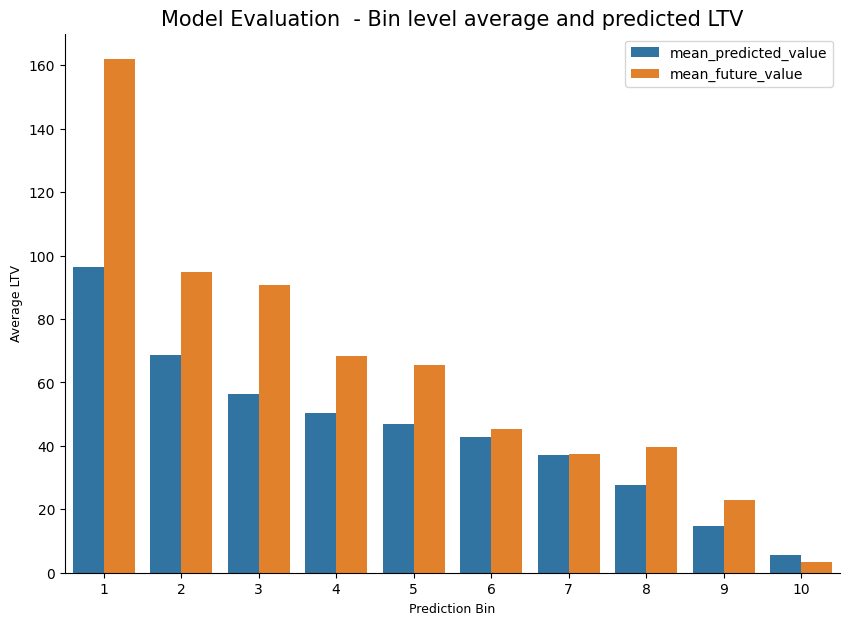

In [8]:
metrics = pipeline.evaluate_model(model_id=MODEL_ID); 

In [9]:
metrics

,time_run,model_id,test_set_rows,spearman_correlation,gini_normalized,normalised_mae,0,top_1_percent_predicted_customers_value_share,top_5_percent_predicted_customers_value_share,top_10_percent_predicted_customers_value_share
0,23/04/2025 15:01:43,815111950135459840,994,0.28,0.47,1.11,NaN,NaN,NaN,NaN


# Generating predictions

Once model training is done, you can generate predictions. Features need to be engineered (the exact same as were used for model training) before prediction. This is done using the `.feature_engineer()` method by setting the parameter `query_type="predict_query"`. The features will be created in a BigQuery table called `crystalvalue_predict_data` by default. The model will make predictions for all customers in the provided input table that have any activity during the lookback window. The pLTV predictions will be for the period starting from the last date in the input table (not today"s date).  

In [ ]:
bq_client = bigquery.Client(credentials=credentials)

In [12]:
from crystalvalue.model_evaluation import get_test_set

crystalvalue_predict_data = get_test_set(
    bigquery_client=bq_client,
    dataset_id=gcp_dataset_id,
    table_name=pipeline.training_table_name,
    location=GCP_LOCATION
)

/Users/pierre-emmanuel/Documents/freelance/pltv/venv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [13]:
predictions = pipeline.predict(
    input_table=crystalvalue_predict_data,
    destination_table="crystalvalue_predictions"  # The bigquery table to append predictions to. It will be created if it does not exist yet.
)  

INFO:absl:Creating table 'pltv-457408.crystalvalue.crystalvalue_predictions' in location 'europe-west4'


In [28]:
query = f"""
WITH 
PredictCustomerIds AS (
SELECT customer_id, lookahead_start, lookahead_stop
FROM `{GCP_PROJECT_ID}.{gcp_dataset_id}.{pipeline.training_table_name}`
WHERE predefined_split_column = 'TEST'
)
SELECT CAST(TX_DATA.customer_id AS STRING) AS customer_id, SUM(TX_DATA.value) AS actual_value
FROM `{GCP_PROJECT_ID}.{gcp_dataset_id}.{GCP_TABLE_ID}` AS TX_DATA
INNER JOIN PredictCustomerIds
ON CAST(TX_DATA.customer_id AS STRING) = PredictCustomerIds.customer_id
WHERE DATE(TX_DATA.date) BETWEEN DATE(PredictCustomerIds.lookahead_start) AND DATE(PredictCustomerIds.lookahead_stop)
GROUP BY CAST(TX_DATA.customer_id AS STRING)
"""
result = bq_client.query(query).result() 
actual = result.to_dataframe()

/Users/pierre-emmanuel/Documents/freelance/pltv/venv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [34]:
final_dataset = pd.merge(predictions, actual, on="customer_id", how="inner")
final_dataset["error"] = final_dataset["predicted_value"] - final_dataset["actual_value"]

In [51]:
final_dataset.actual_value.describe()

count     385.000000
mean      162.733610
std       238.780659
min         5.730000
25%        54.950000
50%       101.210000
75%       194.130000
max      3639.970000
Name: actual_value, dtype: float64

In [ ]:
plot_predictions_vs_actual(final_dataset, max_value=200)

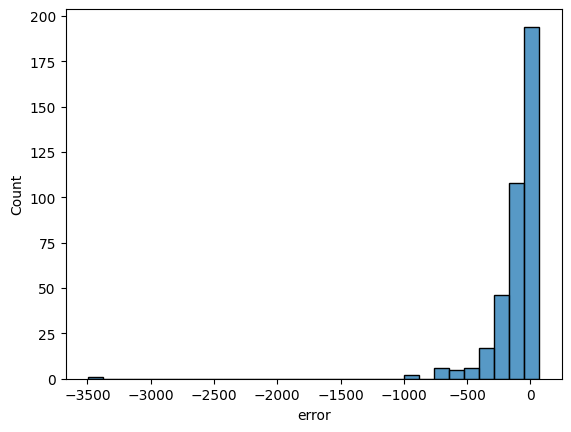

In [53]:
sns.histplot(data=final_dataset, x="error", bins=30); 

In [93]:
metrics = calculate_regression_metrics(final_dataset)

for key, value in metrics.items():
    print(f"{key}: {value:.3f}")

MAE: 116.721
MAPE: 0.575
RMSE: 254.116
R2: -0.136


# Scheduling daily predictions

Crystalvalue uses [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) to schedule and monitor machine learning predictions. It can also be used for model retraining. The example below demonstrates how to set up the model to automatically create predictions using new input data from the source BigQuery table every day at 1am. The frequency and timing of the schedule can be altered using the chron schedule below. Once this pipeline is set up, you can view it [here](https://console.cloud.google.com/vertex-ai/pipelines). If you want a tutorial on how to set up Vertex Pipelines [this guide](https://cloud.google.com/vertex-ai/docs/pipelines/build-pipeline).

In order to use Vertex AI pipelines, we need a cloud storage bucket. Use the code below to create a cloud storage bucket. Note that you may have to grant Storage Object Admin to your service account to ensure the pipeline can run.

In [ ]:
BUCKET_NAME = "crystalvalue_bucket"
storage_bucket = pipeline.create_storage_bucket(bucket_name=BUCKET_NAME)

In order to use Vertex AI pipelines with Crystalvalue we also need to create a docker container which will be stored in Google Cloud Container Registry. The following code builds a docker container and pushes it to your [GCP Container Registry](https://cloud.google.com/container-registry). 


In [ ]:
!docker build -t crystalvalue .
!docker tag crystalvalue gcr.io/$pipeline.project_id/crystalvalue
!docker push gcr.io/$pipeline.project_id/crystalvalue

The Kubeflow components contains self-contained functions. Read about [Kubeflow components](https://www.kubeflow.org/docs/components/pipelines/sdk/component-development/).  

In [ ]:
from kfp import dsl
from kfp import compiler
from kfp.dsl import component


@component(base_image=f"gcr.io/{pipeline.project_id}/crystalvalue:latest")
def pipeline_function():  
  from crystalvalue import crystalvalue
  parameters = crystalvalue.load_parameters_from_file()
  pipeline = crystalvalue.CrystalValue(**parameters)
  TRANSACTION_TABLE = "online_retail_data"  # Add your input table name.
  pipeline.run_data_checks(transaction_table_name=TRANSACTION_TABLE)  
  features = pipeline.feature_engineer(transaction_table_name=TRANSACTION_TABLE,
                                       query_type="predict_query")
  pipeline.predict(features)


@dsl.pipeline(
    name="crystalvaluepipeline",
    pipeline_root=f"gs://{BUCKET_NAME}/pipeline_root",
)
def crystalvalue_pipeline():
    pipeline_function()
    
compiler.Compiler().compile(
  pipeline_func=crystalvalue_pipeline,
  package_path="crystalvaluepipeline.json"
)

In [ ]:
from google.cloud import aiplatform

# Choose a region compatible with Vertex Pipelines. 
# This doesn"t have to be the same as your data location.

PROJECT_ID = pipeline.project_id,
REGION=pipeline.location,
DISPLAY_NAME="crystalvalue_pipeline",
PIPELINE_ROOT=f"gs://{BUCKET_NAME}/pipeline_root",
PACKAGE_PATH="crystalvaluepipeline.json",
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
)

pipeline_job = aiplatform.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path=PACKAGE_PATH,
    pipeline_root=PIPELINE_ROOT,
)

## Check if your pipeline is running.
job.submit()

Create the scheduled pipeline. Adjust time zone and cron schedule as necessary.

In [ ]:
pipeline_job_schedule = pipeline_job.create_schedule(
  display_name="crystalvalue_pipeline_schedule",
  cron="TZ=CRON",
  max_concurrent_run_count=MAX_CONCURRENT_RUN_COUNT,
  max_run_count=MAX_RUN_COUNT,
)

You can view your running and scheduled pipelines at:
https://console.cloud.google.com/vertex-ai/pipelines or by adjusting the code below.

In [ ]:
aiplatform.PipelineJobSchedule.list(
  filter="display_name="DISPLAY_NAME"",
  order_by="create_time desc"
)

# (Optional) Get insights into the relationship between your features and customer LTV

To get insights into how your model is making predictions based on your features using the [What-If Tool](https://pair-code.github.io/what-if-tool/). Check out an [online demo here](https://pair-code.github.io/what-if-tool/demos/age.html).

In [ ]:
import numpy as np

from witwidget.notebook.visualization import WitConfigBuilder
from witwidget.notebook.visualization import WitWidget

In [65]:
features_with_predictions = pd.concat([
    crystalvalue_predict_data.iloc[:,8:],
    predictions["predicted_value"]], axis=1)

In [ ]:
config_builder = WitConfigBuilder(
    np.array(features_with_predictions[0:1000]).tolist(),
    list(features_with_predictions)
)
WitWidget(config_builder, height=1000)

# Custom Model

In [14]:
from custom.config import Config
from custom.data import DataLoader
from custom.models import ModelFactory
from custom.feature_selection import create_feature_selector

## Step 1 - Classification

In [27]:
config = Config.from_yaml()
config

Config(project_id='pltv-457408', dataset_id='crystalvalue_20250424_123433', table_id='crystalvalue_train_data', target_column='future_value_classification', train_val_test_split_column='predefined_split_column', category_columns=['unique_list_order_index', 'unique_list_shipping_address_reg'], excluded_columns=['customer_id', 'window_date', 'lookback_start', 'lookahead_start', 'lookahead_stop', 'future_value'], n_samples=-1, stratified=False, n_trials=50, timeout=3600, random_state=42, storage_name='sqlite:///optuna_study.db', save_dir='./models', feature_selection=True, min_features=5, max_features=50, feature_selection_method='mutual_info')

In [31]:
loader = DataLoader(config=config, gcp_credentials=credentials)
X_train, X_val, y_train, y_val = loader.load_training_data()

/Users/pierre-emmanuel/Documents/freelance/pltv/custom/data.py:101: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  


Downloading: 100%|██████████|


In [33]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((20991, 27), (3928, 27), (20991,), (3928,))

In [32]:
loader.training_data

,predefined_split_column,avg_value,avg_value_cat_1,avg_value_cat_2,avg_value_cat_3,avg_value_cat_4,avg_value_cat_5,avg_value_cat_6,avg_value_uncategorized,unique_list_order_index,unique_list_shipping_address_reg,future_value_classification
0,TRAIN,36.12,0.00,0.00,0.00,0.00,0.00,0.00,36.12,2,reg1,1
1,VALIDATE,70.09,0.00,0.00,8.03,3.99,5.60,0.00,52.47,2,reg11,1
2,TRAIN,44.16,0.00,0.00,1.57,0.00,2.93,0.00,39.66,1,reg11,1
3,TRAIN,14.16,3.60,0.00,2.06,0.00,0.00,0.00,8.50,6,reg8,1
4,VALIDATE,33.95,0.00,0.00,0.00,1.67,5.60,0.00,26.68,3,reg4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
24914,TRAIN,135.16,2.24,2.93,52.74,42.54,30.04,4.67,0.00,1,reg1,0
24915,TRAIN,70.18,1.94,14.18,24.91,29.15,0.00,0.00,0.00,1,reg11,0
24916,VALIDATE,55.45,0.00,0.00,0.00,15.45,0.00,0.00,40.00,1,reg1,0
24917,TRAIN,59.48,0.00,5.00,5.26,34.22,0.00,0.00,15.00,1,reg10,0


In [40]:
clf_model = ModelFactory.create_model(model_name="xgboost_classifier", config=config)
clf_model.fit(X_train, y_train)

In [41]:
y_pred = clf_model.predict(X_val)
custom_data = pd.DataFrame({"predicted_value": y_pred, "actual_value": y_val})

In [42]:
metrics = calculate_classification_metrics(custom_data)

for key, value in metrics.items():
    print(f"{key}: {value:.3f}")

Accuracy: 0.662
Precision: 0.446
Recall: 0.139
F1 Score: 0.212


## Step 2 - Regression

In [43]:
config = Config.from_yaml()

In [44]:
loader = DataLoader(config=config, gcp_credentials=credentials)
X_train, X_val, y_train, y_val = loader.load_training_data(only_positive_samples=True)

/Users/pierre-emmanuel/Documents/freelance/pltv/custom/data.py:101: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  


Downloading: 100%|██████████|


In [46]:
reg_model = ModelFactory.create_model(model_name="linear_regression", config=config)
reg_model.fit(X_train, y_train)

In [47]:
y_pred = reg_model.predict(X_val)
custom_data = pd.DataFrame({"predicted_value": y_pred, "actual_value": y_val})
custom_data["error"] = custom_data["predicted_value"] - custom_data["actual_value"]

In [48]:
metrics = calculate_regression_metrics(custom_data)

for key, value in metrics.items():
    print(f"{key}: {value:.3f}")

MAE: 98.626
MAPE: 1.353
RMSE: 171.666
R2: 0.107


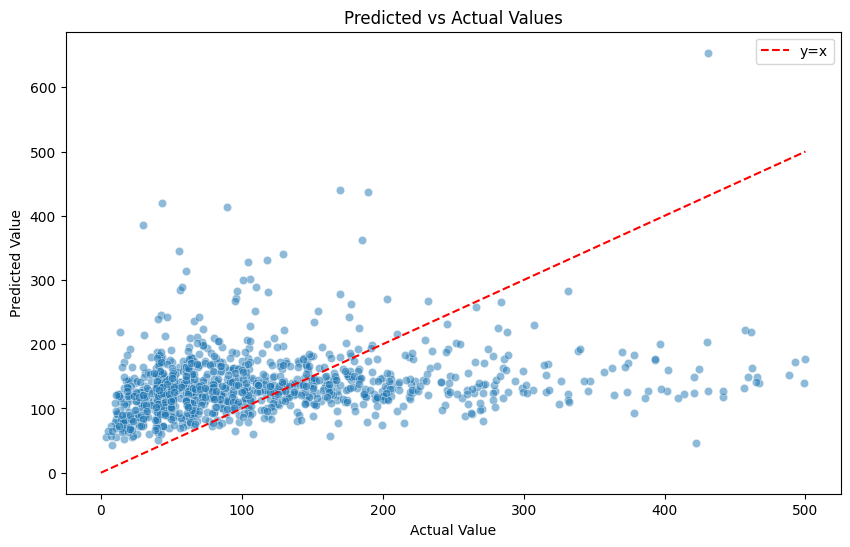

In [49]:
plot_predictions_vs_actual(data=custom_data, max_value=500)

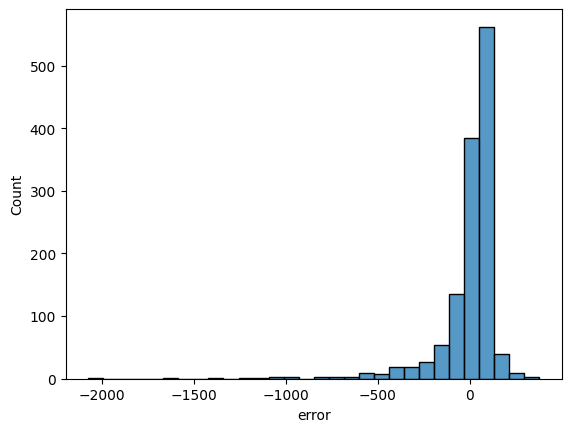

In [51]:
sns.histplot(data=custom_data, x="error", bins=30); 

# Clean Up

To clean up tables created during this demo, delete the BigQuery tables that were created. All Vertex AI resources can be removed from the [Vertex AI console](https://console.cloud.google.com/vertex-ai). If you set up a Vertex Pipeline then also remove any relevant resources from [Cloud Storage](https://console.cloud.google.com/storage) and [Container Registry](https://console.cloud.google.com//gcr/images/). 

In [ ]:
pipeline.delete_table("crystalvalue_data_statistics")
pipeline.delete_table("crystalvalue_evaluation")
pipeline.delete_table("crystalvalue_train_data")
pipeline.delete_table("crystalvalue_predict_data")
pipeline.delete_table("crystalvalue_predictions")